# INFORMACIÓN DEL PROYECTO

### TÍTULO

Titulo = "El quién, el qué y el cuánto del consumo cultural en Cataluña"

In [5]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency, f_oneway
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
#import bootcampviztools as bt
from pandas.plotting import table
from sklearn.inspection import permutation_importance


In [6]:
epcc23 = pd.read_csv("epcc23.csv")

In [7]:
epcc23.head()

,Idioma_preferencia,Residencia_habitual,Quienes_conviven,Cuantos_menores,Cuantas_horas_audiovisuales_ayer,Horas_internet_ayer,Grado_interes_videojuegos,Media_horas_juego_semanal,Multijugador,Juego_nocturno,...,Motivo_visita_biblioteca,Tareas_realizadas,Ambito_asociacionismo,Idioma_en_internet,Usos_internet,Conceptos_asociados_videojuegos,Lengua_habitual_hogar,Dominio_linguistico,valores_positivos_videojuegos,valores_negativos_videojuegos
0,2,3,4,2.0,3.0,3.0,9,2.0,1.0,1.0,...,6,10,0,3,"3,4","1,2,5","1,2,3","1,2,3","[2, 3.0]","[4, 1.0]"
1,2,3,4,1.0,3.0,4.0,10,14.0,1.0,1.0,...,0,0,0,2,"3,4,7","1,2,5",2,1,"[3, 4.0]","[1, 3.0]"
2,1,3,4,2.0,3.0,3.0,8,3.0,0.0,0.0,...,2,2,0,"2,3","3,4",2,1,1,"[1, 3.0]","[6, 1.0]"
3,1,3,5,2.0,5.0,3.0,8,3.0,1.0,0.0,...,2,"1,7",0,2,"3,4","1,2,5","1,2",1,"[3, 2.0]","[4, 1.0]"
4,1,3,0,0.0,4.0,3.0,9,15.0,1.0,1.0,...,2,7,0,"1,2","3,4","1,4,8",1,"1,2","[3, 5.0]","[3, 6.0]"


-------------------------------------

In [8]:
# Por si acaso, hago una copia
epcc23co = epcc23.copy()

In [9]:
# Examino el df
epcc23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4114 entries, 0 to 4113
Columns: 117 entries, Idioma_preferencia to valores_negativos_videojuegos
dtypes: float64(43), int64(28), object(46)
memory usage: 3.7+ MB


#### Breve mapa de variables    
Según su prefijo, las variables indican de qué tratan:
* D = Diarios
* PP = Revistas
* R = Radio
* CA = Contenidos Audiovisuales
* T = Televisión
* IT = Internet
* VJ = Videojuegos
* M = Música
* CO = Conciertos
* CN = Cine
* ES = Espectáculos
* EX = Exposiciones
* LL = Libros
* BI = Bibliotecas
* AS = Asociacionismo
* I = Idiomas
* D = Demografía
* OR = Orígen
* LN = Lenguas
* CS = caracterización sociodemográfica
* G = General
* AmT = Ámbito Territorial

Targets:

In [10]:
targets = ["Media_horas_juego_semanal", "Horas_musica_ayer", "Cuantos_conciertos_año", "Cuantos_festivales_año", "Cuantas_pelis_3_meses", "Cuantos_espectaculos_año",
           "Cuantas_visitas_museo", "Cuantas_visitas_galeria_arte", "Cuantas_visitas_salas_expos", "Cuantas_visitas_monumentos", "Cuantas_expos_otros", "Cuantos_libros_año"]

# Separar las características y los targets
X = epcc23.drop(columns=targets)

y1 = epcc23["Media_horas_juego_semanal"]
y2 = epcc23["Horas_musica_ayer"]
y3 = epcc23[["Cuantos_conciertos_año", "Cuantos_festivales_año"]].sum(axis=1)  # Sumo las variables relacionadas con número de conciertos y de festivales
y4 = epcc23["Cuantas_pelis_3_meses"]
y5 = epcc23["Cuantos_espectaculos_año"]
y6 = epcc23[["Cuantas_visitas_museo", "Cuantas_visitas_galeria_arte", "Cuantas_visitas_salas_expos", "Cuantas_visitas_monumentos", "Cuantas_expos_otros"]].sum(axis=1)  # Sumar las columnas relacionadas con museos, galerías y otros.
y7 = epcc23["Cuantos_libros_año"]

In [11]:
print(len(X), len(y1), len(y2), len(y3), len(y4), len(y5), len(y6), len(y7))

4114 4114 4114 4114 4114 4114 4114 4114


II. Prediccion con Regresión

Ahora vamos a intentar predecir los diferentes targets para nuestros usuarios.

Recordamos que los targets son:


In [12]:
targets = ["Media_horas_juego_semanal", "Horas_musica_ayer", "Cuantos_conciertos_año", "Cuantos_festivales_año", "Cuantas_pelis_3_meses", "Cuantos_espectaculos_año",
           "Cuantas_visitas_museo", "Cuantas_visitas_galeria_arte", "Cuantas_visitas_salas_expos", "Cuantas_visitas_monumentos", "Cuantas_expos_otros", "Cuantos_libros_año"]

Y que además tenemos que quitar las columnas que hemos creado en las 2 clusterizaciones:

In [13]:
columnas_clusters = [col for col in epcc23.columns if col.startswith('Clu.')]

In [14]:
epcc23_pred = epcc23.drop(columns = columnas_clusters)

Pero vamos a intentar predecir, primero, de a uno.

Lo primero será dividir nuestro dataset en X e y, y en train y test:

In [15]:
# Mi X:
X = epcc23_pred.drop(columns = targets)

# Mis features son estas, así agrupadas
epcc23_pred['VJ'] = epcc23_pred['Media_horas_juego_semanal']
epcc23_pred['MU'] = epcc23_pred['Horas_musica_ayer']
epcc23_pred['CO_FE'] = epcc23_pred['Cuantos_conciertos_año'] + epcc23_pred['Cuantos_festivales_año']
epcc23_pred['CI'] = epcc23_pred['Cuantas_pelis_3_meses']
epcc23_pred['ES'] = epcc23_pred['Cuantos_espectaculos_año']
epcc23_pred['EX'] = (epcc23_pred['Cuantas_visitas_museo'] +
                     epcc23_pred['Cuantas_visitas_galeria_arte'] +
                     epcc23_pred['Cuantas_visitas_salas_expos'] +
                     epcc23_pred['Cuantas_visitas_monumentos'] +
                     epcc23_pred['Cuantas_expos_otros'])
epcc23_pred['LI'] = epcc23_pred['Cuantos_libros_año']

# Aquí las pongo como targets
y1 = epcc23_pred['VJ']
y2 = epcc23_pred['MU']
y3 = epcc23_pred[['Cuantos_conciertos_año', 'Cuantos_festivales_año']].sum(axis=1)
y4 = epcc23_pred['CI']
y5 = epcc23_pred['ES']
y6 = epcc23_pred[['Cuantas_visitas_museo', 'Cuantas_visitas_galeria_arte', 'Cuantas_visitas_salas_expos',
                  'Cuantas_visitas_monumentos', 'Cuantas_expos_otros']].sum(axis=1)
y7 = epcc23_pred['LI']

In [16]:
# Dividir el dataset en conjunto de entrenamiento y prueba para cada target
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_test = train_test_split(X, y3, test_size=0.2, random_state=42)
_, _, y4_train, y4_test = train_test_split(X, y4, test_size=0.2, random_state=42)
_, _, y5_train, y5_test = train_test_split(X, y5, test_size=0.2, random_state=42)
_, _, y6_train, y6_test = train_test_split(X, y6, test_size=0.2, random_state=42)
_, _, y7_train, y7_test = train_test_split(X, y7, test_size=0.2, random_state=42)

In [17]:
# Mostrar las formas de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Tamaño de y1_train:", y1_train.shape)
print("Tamaño de y1_test:", y1_test.shape)
print("Tamaño de y2_train:", y2_train.shape)
print("Tamaño de y2_test:", y2_test.shape)
print("Tamaño de y3_train:", y3_train.shape)
print("Tamaño de y3_test:", y3_test.shape)
print("Tamaño de y4_train:", y4_train.shape)
print("Tamaño de y4_test:", y4_test.shape)
print("Tamaño de y5_train:", y5_train.shape)
print("Tamaño de y5_test:", y5_test.shape)
print("Tamaño de y6_train:", y6_train.shape)
print("Tamaño de y6_test:", y6_test.shape)
print("Tamaño de y7_train:", y7_train.shape)
print("Tamaño de y7_test:", y7_test.shape)

Tamaño del conjunto de entrenamiento: (3291, 105)
Tamaño del conjunto de prueba: (823, 105)
Tamaño de y1_train: (3291,)
Tamaño de y1_test: (823,)
Tamaño de y2_train: (3291,)
Tamaño de y2_test: (823,)
Tamaño de y3_train: (3291,)
Tamaño de y3_test: (823,)
Tamaño de y4_train: (3291,)
Tamaño de y4_test: (823,)
Tamaño de y5_train: (3291,)
Tamaño de y5_test: (823,)
Tamaño de y6_train: (3291,)
Tamaño de y6_test: (823,)
Tamaño de y7_train: (3291,)
Tamaño de y7_test: (823,)


Anñalisis de los datos y EDA

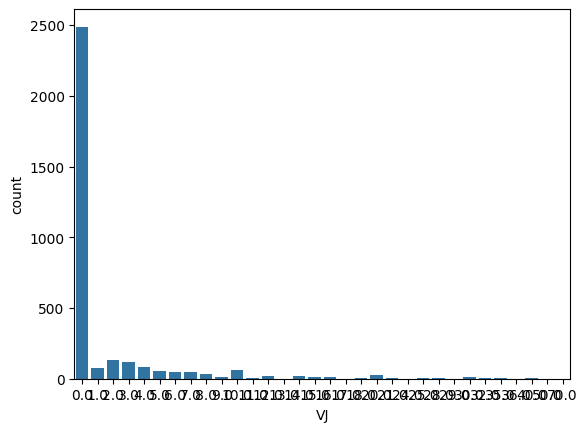

In [18]:
# distribución variable? balanceado o no?

sns.countplot(x = y1_train, data = X_train);

In [19]:
# histoplots de los targets
sns.histplot(df["alcohol"])

NameError: name 'df' is not defined

Análisis bivariante

In [ ]:
# target contra la categórica
bt.plot_categorical_relationship_fin(df_eda, "quality", "class", relative_freq=True, show_values=True)

Anñalisis multivariante

In [ ]:
df_eda.describe()

In [ ]:
df_eda.hist()

In [ ]:
#matriz de correlación
df_eda.corr(numeric_only= True)

In [ ]:
corr_matrix = df_eda.corr(numeric_only= True)
corr_matrix["alcohol"].abs().sort_values(ascending = False)

In [ ]:
corr_matrix = df_eda.corr(numeric_only= True)
corr_matrix["quality"].abs().sort_values(ascending = False)

In [ ]:
columnas = corr_matrix["alcohol"][corr_matrix["alcohol"].abs() > 0.05].index.to_list()
if 'alcohol' in columnas:
    columnas.remove('alcohol')
columnas

In [ ]:
sns.pairplot(df_eda[columnas]);

In [ ]:
sns.heatmap(df_eda.corr(numeric_only = True),annot=True);
plt.show();

Modelado

In [ ]:
X_train.columns

In [ ]:
X_train
X_train1 = pd.concat([X_train, y2_train], axis=1)
X_test
X_test1 = pd.concat([X_test, y2_test], axis=1)

features = X_train.columns
features2 = X_train1.columns

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

X_train1_scaled = pd.DataFrame(scaler.fit_transform(X_train1), columns=features2)
X_test1_scaled = pd.DataFrame(scaler.transform(X_test1), columns=features2)

In [ ]:
model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor(random_state= 42)
rf_clf = RandomForestRegressor(random_state= 42)
xgb_clf = XGBRegressor(random_state = 42)
lgb_clf = LGBMRegressor(random_state= 42, verbose = -100)
cat_clf = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]

In [ ]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y2_train, cv = 3, scoring = "neg_mean_squared_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y2_train, cv = 3, scoring = "neg_mean_squared_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")

In [ ]:
catb_rg = CatBoostRegressor(verbose = False)

params_grid = {
    'iterations': [150, 200, 100],
    'learning_rate': [0.2, 0.4, 0.6, 0.9],
    'verbose' : [False]
}

catb_grid = GridSearchCV(catb_rg,
                       param_grid= params_grid,
                       cv = 3,
                       scoring = "recall_macro",
                       n_jobs = -1)

catb_grid.fit(X_train, y2_train)

In [ ]:
np.sqrt(catb_grid.best_score_)

In [ ]:
catb_grid.best_params_

In [ ]:
y2_pred = catb_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y2_test,y2_pred))
print("MAPE:", mean_absolute_percentage_error(y2_test,y2_pred))
print("RMSE:", np.sqrt(mean_squared_error(y2_test, y2_pred)))
# Ha subido de 0.36 a 0.38

In [ ]:
metricas_optimizadas = {}

In [ ]:
param_grid = {
    "alpha": [0.1, 1, 10, 100],
    "l1_ratio": [0.2,0.4,0.6,1]

}
model = CatBoostRegressor()
lr_grid = RandomizedSearchCV( model,
                             cv = 3,
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= "neg_mean_squared_error"
)

catb_grid.fit(X_train_scaled,y2_train)
print("LR best_score:", np.sqrt(-catb_grid.best_score_))
metricas_optimizadas["Linear Regresion"] = np.sqrt(-catb_grid.best_score_)